# **1: Konfigurasi & Setup Awal**

In [1]:
import os
import random
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torchvision.utils as vutils

# Konfigurasi Parameter
params = {
    'zip_path': 'anime_faces.zip',   # Nama file zip dataset
    'data_root': 'dataset_extracted', # Folder tujuan ekstrak
    'workers': 0,        
    'batch_size': 64,    # Jumlah gambar per proses
    'image_size': 64,    # Ukuran gambar 64x64 pixel
    'nc': 3,             # Jumlah channel warna (3 = RGB)
    'nz': 100,           # Ukuran vektor noise (bahan baku gambar)
    'ngf': 64,           # Ukuran fitur map Generator
    'ndf': 64,           # Ukuran fitur map Discriminator
    'num_epochs': 100,    
    'lr': 0.0002,        # Learning rate (kecepatan belajar)
    'beta1': 0.5,        # Parameter optimizer Adam
    'seed': 999          # Angka acak biar hasil konsisten
}

# Set seed supaya hasil bisa direproduksi
random.seed(params['seed'])
torch.manual_seed(params['seed'])
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"Sistem Siap. Menggunakan Device: {device}")

Sistem Siap. Menggunakan Device: cuda:0


# **2: Persiapan Data (Extract & Load)**

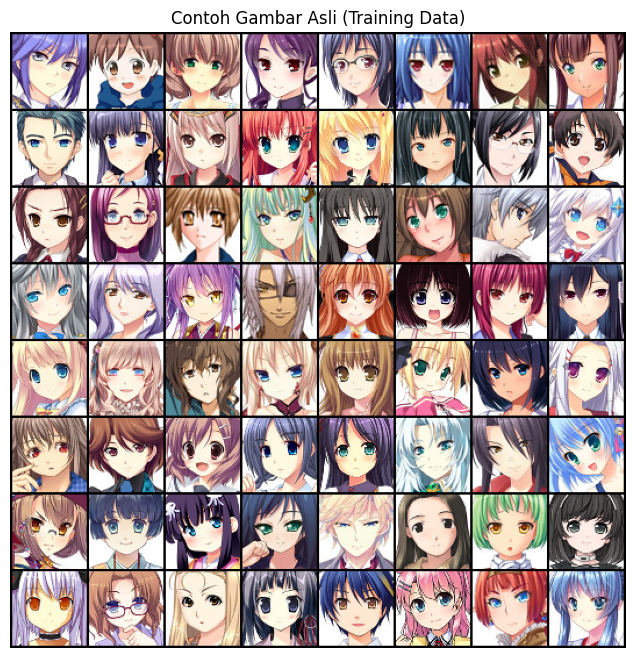

Data siap diproses. Total gambar: 43102


In [2]:
# 1. Ekstrak Dataset (jika belum ada)
if os.path.exists(params['zip_path']):
    if not os.path.exists(params['data_root']):
        print("Sedang mengekstrak dataset, mohon tunggu...")
        with zipfile.ZipFile(params['zip_path'], 'r') as zip_ref:
            zip_ref.extractall(params['data_root'])
else:
    print(f"Error: File {params['zip_path']} tidak ditemukan.")

# 2. Cari folder gambar yang valid
target_root = params['data_root']
for root, dirs, files in os.walk(params['data_root']):
    # Cek apakah ada file gambar png/jpg di folder ini
    if any(f.lower().endswith(('.png', '.jpg')) for f in files):
        target_root = os.path.dirname(root)
        break

# 3. Buat Dataset & DataLoader
dataset = dsets.ImageFolder(root=target_root,
                           transform=transforms.Compose([
                               transforms.Resize(params['image_size']),
                               transforms.CenterCrop(params['image_size']),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, 
                                         batch_size=params['batch_size'],
                                         shuffle=True, 
                                         num_workers=params['workers'])

# 4. Tampilkan contoh gambar asli
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Contoh Gambar Asli (Training Data)")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

print(f"Data siap diproses. Total gambar: {len(dataset)}")

# **3: Arsitektur Model (Generator & Discriminator)**

In [3]:
# Inisialisasi Bobot (agar training lebih stabil di awal)
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Kelas Generator (Si Pembuat Gambar)
class Generator(nn.Module):
    def __init__(self, nz, ngf, nc):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input adalah Z (Noise), masuk ke convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # Ukuran state: (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # Ukuran state: (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # Ukuran state: (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # Ukuran state: (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # Output akhir: (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

# Kelas Discriminator (Si Penilai Gambar)
class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Input: (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # Ukuran state: (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # Ukuran state: (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # Ukuran state: (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # Ukuran state: (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


# **4: Inisialisasi Model & Optimizer**

In [4]:
# Membuat objek model
netG = Generator(params['nz'], params['ngf'], params['nc']).to(device)
netD = Discriminator(params['nc'], params['ndf']).to(device)

# Terapkan inisialisasi bobot
netG.apply(weights_init)
netD.apply(weights_init)

# Fungsi Loss (Menggunakan Binary Cross Entropy)
criterion = nn.BCELoss()

# Setup Optimizer (Menggunakan Adam)
optimizerD = optim.Adam(netD.parameters(), lr=params['lr'], betas=(params['beta1'], 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=params['lr'], betas=(params['beta1'], 0.999))

# Noise tetap untuk memantau perkembangan gambar
fixed_noise = torch.randn(64, params['nz'], 1, 1, device=device)
real_label = 1.
fake_label = 0.

print("Model dan Optimizer berhasil diinisialisasi.")

Model dan Optimizer berhasil diinisialisasi.


# **5: Proses Training (Loop Utama)**

In [ ]:
img_list = []
G_losses = []
D_losses = []

print("Mulai Proses Training...")

for epoch in range(params['num_epochs']):
    for i, data in enumerate(dataloader, 0):

        # (1) Update jaringan D (Discriminator)
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        
        # Latih dengan gambar asli
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()
        
        # Latih dengan gambar palsu (buatan Generator)
        noise = torch.randn(b_size, params['nz'], 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        
        errD = errD_real + errD_fake
        optimizerD.step()

        # (2) Update jaringan G (Generator)
        netG.zero_grad()
        label.fill_(real_label)  # label palsu dianggap asli agar generator belajar
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Simpan nilai Loss untuk grafik
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Tampilkan status log
        if i % 100 == 0:
            print(f'[{epoch}/{params["num_epochs"]}][{i}/{len(dataloader)}] '
                  f'Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f}')

    # Simpan hasil generate gambar per epoch
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
    img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

print("Training selesai!")
